# CS517 Final Project: Single Image Dehazing

## Ritik Garg
### 2019CSB1112

In [1]:
# Importing the required libraries
from PIL import Image
from matplotlib import pyplot as plt
import numpy as np
import cv2

## Helper functions

In [2]:
# Function to determine the gradient of an image
def gradient(img):
    scale = 1
    delta = 0
    ddepth = cv2.CV_16S
    
    Gx = cv2.Sobel(img, ddepth, 1, 0, ksize=3, scale=scale, delta=delta, borderType=cv2.BORDER_DEFAULT) # Horizontal Sobel derivative 
    Gy = cv2.Sobel(img, ddepth, 0, 1, ksize=3, scale=scale, delta=delta, borderType=cv2.BORDER_DEFAULT) # Vertical Sobel derivative 
   
    # Magnitude of the gradient
    G = np.hypot(Gx, Gy)
    return G

## Scene segmentation

In [3]:
# Function to divide arrImg into patches of size (patchSize, patchSize)
def partitionIntoPatches(arrImg, patchSize):
    patches = [] # List of patches
    
    # patchDimensions[i] = (startRowIdx, endRowIdx, startColIdx, endColIdx) => patchs[i] = arrImg[startRowIdx:endRowIdx, startColIdx:endColIdx]
    patchDimensions = []
    rows, cols = arrImg.shape
    for i in range(0, int(np.ceil(rows/patchSize))):
        for j in range(0, int(np.ceil(cols/patchSize))):
            startRowIdx = i*patchSize
            endRowIdx = min((i+1)*patchSize, rows)
            startColIdx = j*patchSize
            endColIdx = min((j+1)*patchSize, cols)
            
            patch = arrImg[startRowIdx : endRowIdx, startColIdx : endColIdx] # Slicing arrImg into a patch
            patches.append(patch) # Appending the patch to the list of patches
            patchDimensions.append((startRowIdx, endRowIdx, startColIdx, endColIdx)) # Storing the dimensions of the corresponding patch
    return patches, patchDimensions
    

In [4]:
# Function to calculate haze density for every patch in patches
def calculateHazeDensity(patches):
    V_i = []
    for patch in patches:
        V_i.append(np.mean(patch) - np.std(patch))
    return V_i
    

In [5]:
# Function to determine the haze distribution map V(x, y), where V(x, y) = V_i such that (x, y) belongs to the i-th patch
def calculateHazeDistributionMap(totalRows, totalCols, patchDimensions, V_i):
    V_x_y = np.zeros((totalRows, totalCols))
    
    for i, dimensions in enumerate(patchDimensions):
        V_x_y[dimensions[0]:dimensions[1], dimensions[2]:dimensions[3]] = V_i[i] # Broadcasting the value of V_i for a patch to every pixel (x, y) belonging to the patch
    
    return V_x_y

In [6]:
# Dividing the image into k scenes using the haze distribution map V(x, y) of the image
def calculateSceneSegmentationMap(V_x_y, k):
    V_sort = np.sort(V_x_y.flatten())
    rows, cols = V_x_y.shape
    C_x_y = np.zeros((rows, cols))
    l = rows * cols
    for x in range(0, rows):
        for y in range(0, cols):
            for i in range(1, k + 1):
                t1 = int(np.floor(((i - 1) * l) / k))
                t2 = int(np.floor((i * l) / k))
                
                # Determining the scene for every pixel using the condition for scene segmentation
                if(V_sort[max(t1, 1) - 1] <= V_x_y[x, y] and V_x_y[x, y] <= V_sort[t2 - 1]):
                    C_x_y[x, y] = i
                    break
    return C_x_y
                

## Scene Luminance Map Estimation

In [7]:
def sceneLuminanceEstimation(arrImg, C_x_y, k):
    kernel = np.ones((5, 5), np.uint8) # Kernal for performing erosion
    arrImgCRed, arrImgCGreen, arrImgCBlue = arrImg[:, :, 0], arrImg[:, :, 1], arrImg[:, :, 2] # Dividing the image into RGB color channels
    
    # Performing erosion for each color channel
    erodedArrImgCRed = cv2.erode(arrImgCRed, kernel, iterations=1)
    erodedArrImgCGreen = cv2.erode(arrImgCGreen, kernel, iterations=1)
    erodedArrImgCBlue = cv2.erode(arrImgCBlue, kernel, iterations=1)  
    
    rows, cols = arrImg.shape[0], arrImg.shape[1]
    sceneLuminanceMapCRed = np.zeros((rows, cols))
    sceneLuminanceMapCGreen = np.zeros((rows, cols))
    sceneLuminanceMapCBlue = np.zeros((rows, cols))
    
    L_r, L_g, L_b = [], [], [] # Channel-wise scene luminance values
    
    for i in range(1, k + 1):
        
        # Extracting the values of eroded channels for ith scene
        sceneErodedValuesCRed = erodedArrImgCRed[C_x_y == i]
        sceneErodedValuesCGreen = erodedArrImgCGreen[C_x_y == i]
        sceneErodedValuesCBlue = erodedArrImgCBlue[C_x_y == i]
        
        # Sorting the pixel intensities after erosion (for ith scene)
        sortedSceneErodedValuesCRed = np.flip(np.sort(sceneErodedValuesCRed))
        sortedSceneErodedValuesCGreen = np.flip(np.sort(sceneErodedValuesCGreen))
        sortedSceneErodedValuesCBlue = np.flip(np.sort(sceneErodedValuesCBlue))
        
        # Averaging top 0.1 brightest pixels in each eroded color channel to obtain the corresponding scene luminance
        sceneLuminanceValueCRed = np.mean(sortedSceneErodedValuesCRed[0 : int(np.ceil(0.1 * len(sceneErodedValuesCRed)))])
        sceneLuminanceValueCGreen = np.mean(sortedSceneErodedValuesCGreen[0 : int(np.ceil(0.1 * len(sceneErodedValuesCGreen)))])
        sceneLuminanceValueCBlue = np.mean(sortedSceneErodedValuesCBlue[0 : int(np.ceil(0.1 * len(sceneErodedValuesCBlue)))])
        
        L_r.append(sceneLuminanceValueCRed)
        L_g.append(sceneLuminanceValueCGreen)
        L_b.append(sceneLuminanceValueCBlue)
        
        # Broadcasting the luminance values for each scene to every pixel belonging to the scene
        sceneLuminanceMapCRed[C_x_y == i] = sceneLuminanceValueCRed
        sceneLuminanceMapCGreen[C_x_y == i] = sceneLuminanceValueCGreen
        sceneLuminanceMapCBlue[C_x_y == i] = sceneLuminanceValueCBlue
        
    return L_r, L_g, L_b, sceneLuminanceMapCRed, sceneLuminanceMapCGreen, sceneLuminanceMapCBlue       
    

## Scene Transmission Map Estimation

In [8]:
def sceneTransmissionEstimation(arrImg, C_x_y, L_r, L_g, L_b, V_x_y, k):
    arrImgCRed, arrImgCGreen, arrImgCBlue = arrImg[:, :, 0], arrImg[:, :, 1], arrImg[:, :, 2] # Splitting the image into RGB color channels
    
    # Calculating the gradient of each channel
    delta_I_r = gradient(arrImgCRed)
    delta_I_g = gradient(arrImgCGreen)
    delta_I_b = gradient(arrImgCBlue)
    
    # Estimating the scene transmission by maximizing the contrast of each scene
    T_hat = []
    rows, cols = arrImg.shape[0], arrImg.shape[1]
    for i in range(1, k + 1):
        currMinDeltaRho = np.inf
        for T_i in np.arange(0.1, 1, 0.1):
            delta_rho = 0
            for x in range(0, rows):
                for y in range(0, cols):
                    if(C_x_y[x, y] == i):
                        delta_rho += delta_I_r[x, y]/(L_r[i - 1] * T_i) + delta_I_g[x, y]/(L_g[i - 1] * T_i) + delta_I_b[x, y]/(L_b[i - 1] * T_i)
            delta_rho *= -1
            
            # Taking arg min of the expression for T_i
            if(delta_rho < currMinDeltaRho):
                currMinDeltaRho = delta_rho
                currMinTi = T_i
        T_hat.append(currMinTi) 
    
    # Measuring the haze thickness of each scene by averaging V(x, y) of all the pixels in a scene
    X_i = []
    for i in range(1, k + 1):
        X_i.append(np.mean(V_x_y[C_x_y == i]))
    
    # Normalizing the values of X_i into range [0, 1]
    X_i = X_i / np.max(X_i)
    
    # Calculating the adjustment magnitude
    M_i = []
    omega = 0.15
    for i in range(1, k + 1):
        M_i.append(2 - np.exp(-1 * (np.square(X_i[i - 1] - 0.5))/(2*omega*omega)))
    
    # Adjusting the scene transmission
    T_tilde = np.array(M_i) * np.array(T_hat)
    
    # Scene transmission map for the image
    sceneTransmissionMap = np.zeros((rows, cols))
    for i in range(1, k + 1):
        sceneTransmissionMap[C_x_y == i] = T_tilde[i - 1]
        
    return sceneTransmissionMap

## Edge Optimization

In [9]:
def createFilterForG(r):
    f = np.full((r, r), -1)
    f[(r - 1)//2, (r - 1)//2] = r*r - 1
    return f

In [10]:
def createFilterForTrefine(r):
    f = np.full((r, r), 1)
    f[(r - 1)//2, (r - 1)//2] = 0
    return f

In [11]:
# Function to perform edge optimization based on a guided total variation model
def edgeOptimization(height, width, G, T, threshold):
    # Initialising the regularization parameters
    alpha = 3
    gamma = 4
    r = max(height, width)//15
    l = height * width
    
    # Creating the required filters
    filterG = createFilterForG(r)
    filterTrefine = createFilterForTrefine(r)
    
    # Appling the filter filterG on the guiding image G
    filteredG = cv2.filter2D(G, -1, filterG)
    
    # Calculating the weight for the guiding image G
    delta_G = gradient(G)
    W = 1 - np.exp(-1 * delta_G)
    
    # Calculating the first half of the numerator(which is independent of the iteration)
    term1 = alpha * T + gamma * W * filteredG
    
    # Initializing the variables for the iteration
    T_prev_refine = T
    iter = 1
    
    # Iteratively refining T
    while True:
        beta = 3 * (iter - 1)
        multiplier = W * (gamma - beta) + beta
        
        # Applying the filter filterTrefine on the value of refined T in the previous iteration
        filteredTPrevRefine = cv2.filter2D(T_prev_refine, -1, filterTrefine)
        term2 = multiplier * filteredTPrevRefine
        
        # Calculating refined T for this iteration
        numerator = term1 + term2
        denominator = alpha + (r * r - 1) * multiplier
        T_refine = numerator/denominator
        
        # Calculating the refinement difference
        diff = np.sum(np.square(T_refine - T_prev_refine)) / l
        
        # Checking if the refinement difference has reached below the required threshold
        if(diff <= threshold):
            break

        T_prev_refine = T_refine
        iter += 1
    
    return T_refine

## Image restoration

In [12]:
def imageRestoration(arrImg, L_r_refine, L_g_refine, L_b_refine, T_refine):
    I_r, I_g, I_b = arrImg[:, :, 0], arrImg[:, :, 1], arrImg[:, :, 2] # Splitting the image into RGB color channels
    
    # Calculating the scene reflectance ρ for each channel
    rho_r = 1 + (I_r - L_r_refine)/(L_r_refine * T_refine)
    rho_g = 1 + (I_g - L_g_refine)/(L_g_refine * T_refine)
    rho_b = 1 + (I_b - L_b_refine)/(L_b_refine * T_refine)
    
    # Obtaining the restoration results by restricting ρ in the range [0,1]
    R_r = np.minimum(np.maximum(rho_r, 0), 1)
    R_g = np.minimum(np.maximum(rho_g, 0), 1)
    R_b = np.minimum(np.maximum(rho_b, 0), 1)
    
    # Merging the restoration results of all channels to obtain the final restored image
    R = np.zeros(arrImg.shape)
    R[:, :, 0] = R_r
    R[:, :, 1] = R_g
    R[:, :, 2] = R_b
    
    return R

## Single Image Dehazing

In [13]:
def HazeRemoval(imgPath, thresholdT, thresholdLr, thresholdLg, thresholdLb, k, patchSize):
    
    # Getting the image
    img = Image.open(imgPath)
    grayScaleImg = img.convert('L')
    arrImg = np.array(img)
    arrGrayScaleImg = np.array(grayScaleImg)
    tRows, tCols = arrGrayScaleImg.shape

    plt.title('Original Image')
    plt.imshow(img)
    
    plt.show()
    
    # Scene Segmentation
    patches, patchDimensions = partitionIntoPatches(arrGrayScaleImg, patchSize)
    V_i = calculateHazeDensity(patches)
    V_x_y = calculateHazeDistributionMap(tRows, tCols, patchDimensions, V_i)
    C_x_y = calculateSceneSegmentationMap(V_x_y, k)

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)
    plt.title('Original Image')
    plt.imshow(img)

    plt.subplot(1, 2, 2)
    plt.title('Scene Segmentation Map')
    plt.imshow(C_x_y)
    
    plt.show()
    
    # Scene Luminance Map Estimation
    L_r, L_g, L_b, sceneLuminanceMapCRed, sceneLuminanceMapCGreen, sceneLuminanceMapCBlue = sceneLuminanceEstimation(arrImg, C_x_y, k)

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 4, 1)
    plt.title('Original Image')
    plt.imshow(img)

    plt.subplot(1, 4, 2)
    plt.title('Scene Luminance Map (Red)')
    plt.imshow(sceneLuminanceMapCRed, cmap='Reds_r')

    plt.subplot(1, 4, 3)
    plt.title('Scene Luminance Map (Green)')
    plt.imshow(sceneLuminanceMapCGreen, cmap='Greens_r')

    plt.subplot(1, 4, 4)
    plt.title('Scene Luminance Map (Blue)')
    plt.imshow(sceneLuminanceMapCBlue, cmap='Blues_r')
    
    plt.show()
    
    # Scene Transmission Map Estimation
    sceneTransmissionMap = sceneTransmissionEstimation(arrImg, C_x_y, L_r, L_g, L_b, V_x_y, k)

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)
    plt.title('Original Image')
    plt.imshow(img)

    plt.subplot(1, 2, 2)
    plt.title('Scene Transmission Map')
    plt.imshow(sceneTransmissionMap)
    
    plt.show()
    
    # Edge Optimization
    T_refine = edgeOptimization(tRows, tCols, arrGrayScaleImg, sceneTransmissionMap, thresholdT)
    L_r_refine = edgeOptimization(tRows, tCols, arrGrayScaleImg, sceneLuminanceMapCRed, thresholdLr)
    L_g_refine = edgeOptimization(tRows, tCols, arrGrayScaleImg, sceneLuminanceMapCGreen, thresholdLg)
    L_b_refine = edgeOptimization(tRows, tCols, arrGrayScaleImg, sceneLuminanceMapCBlue, thresholdLb)

    plt.figure(figsize=(15, 19))

    plt.subplot(4, 2, 1)
    plt.title('Scene Transmission Map')
    plt.imshow(sceneTransmissionMap)

    plt.subplot(4, 2, 2)
    plt.title('Refined Scene Transmission Map')
    plt.imshow(T_refine)

    plt.subplot(4, 2, 3)
    plt.title('Scene Luminance Map (Red)')
    plt.imshow(sceneLuminanceMapCRed, cmap='Reds_r')

    plt.subplot(4, 2, 4)
    plt.title('Refined Scene Luminance Map (Red)')
    plt.imshow(L_r_refine, cmap='Reds_r')

    plt.subplot(4, 2, 5)
    plt.title('Scene Luminance Map (Green)')
    plt.imshow(sceneLuminanceMapCGreen, cmap='Greens_r')

    plt.subplot(4, 2, 6)
    plt.title('Refined Scene Luminance Map (Green)')
    plt.imshow(L_g_refine, cmap='Greens_r')

    plt.subplot(4, 2, 7)
    plt.title('Scene Luminance Map (Blue)')
    plt.imshow(sceneLuminanceMapCBlue, cmap='Blues_r')

    plt.subplot(4, 2, 8)
    plt.title('Refined Scene Luminance Map (Blue)')
    plt.imshow(L_b_refine, cmap='Blues_r')
    
    plt.show()
    
    # Image Restoration
    finalDehazedImg = imageRestoration(arrImg, L_r_refine, L_g_refine, L_b_refine, T_refine)

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)
    plt.title('Original Image')
    plt.imshow(img)

    plt.subplot(1, 2, 2)
    plt.title('Dehazed Image')
    plt.imshow(finalDehazedImg)

## Sample Runs

The various parameters (like _thresholds_, _patch size_, _number of scenes_, etc.) are subject to variability. They can be adjusted to obtain the best restoration results.

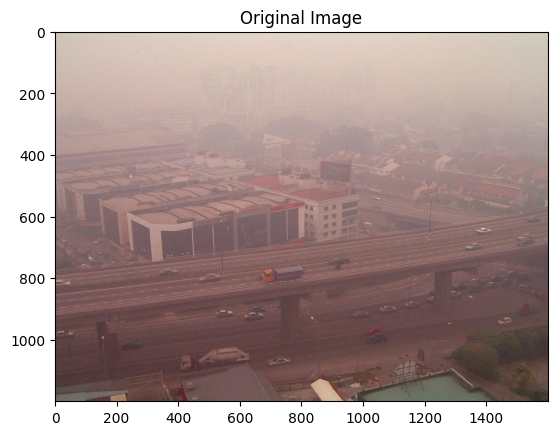

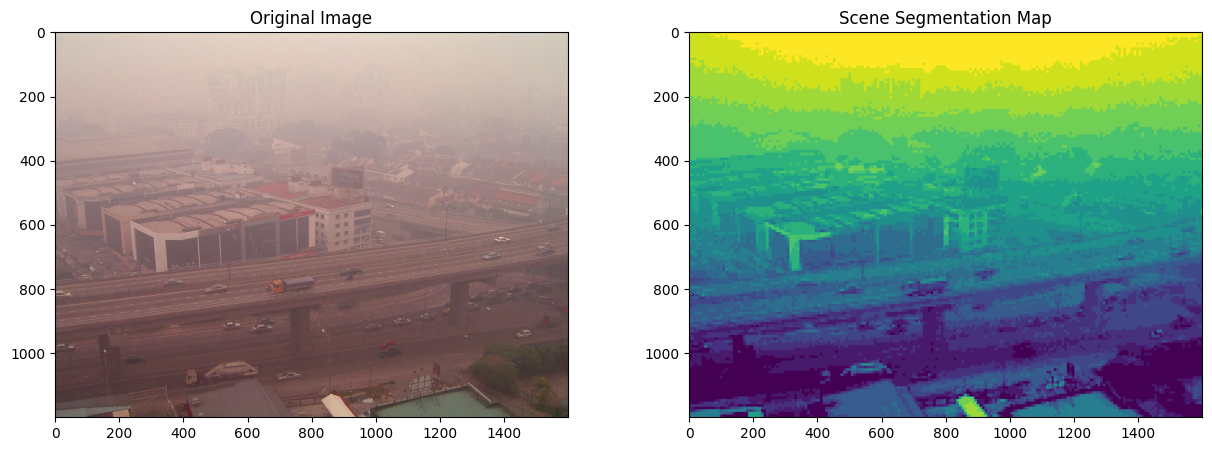

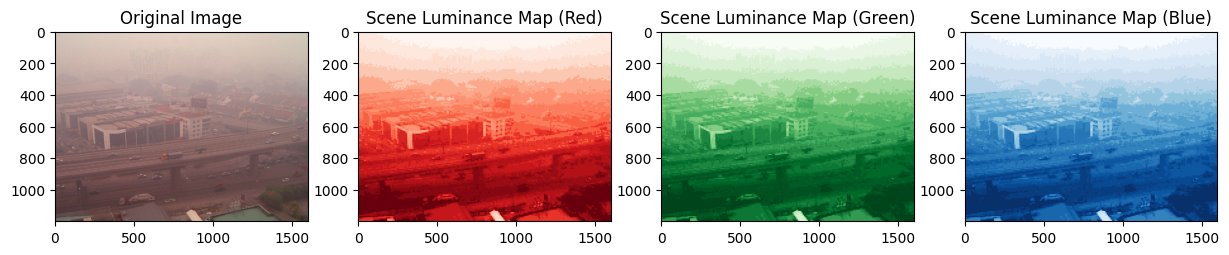

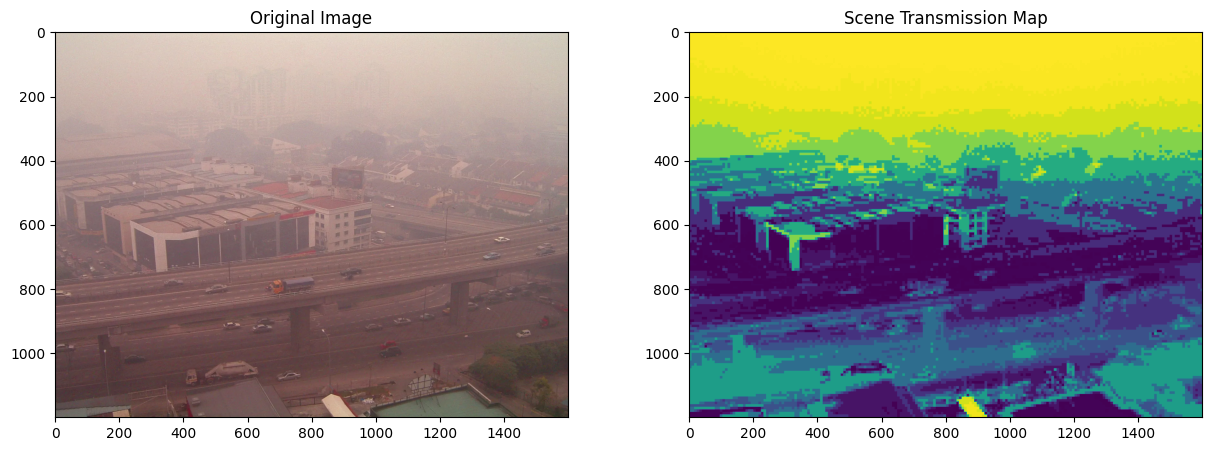

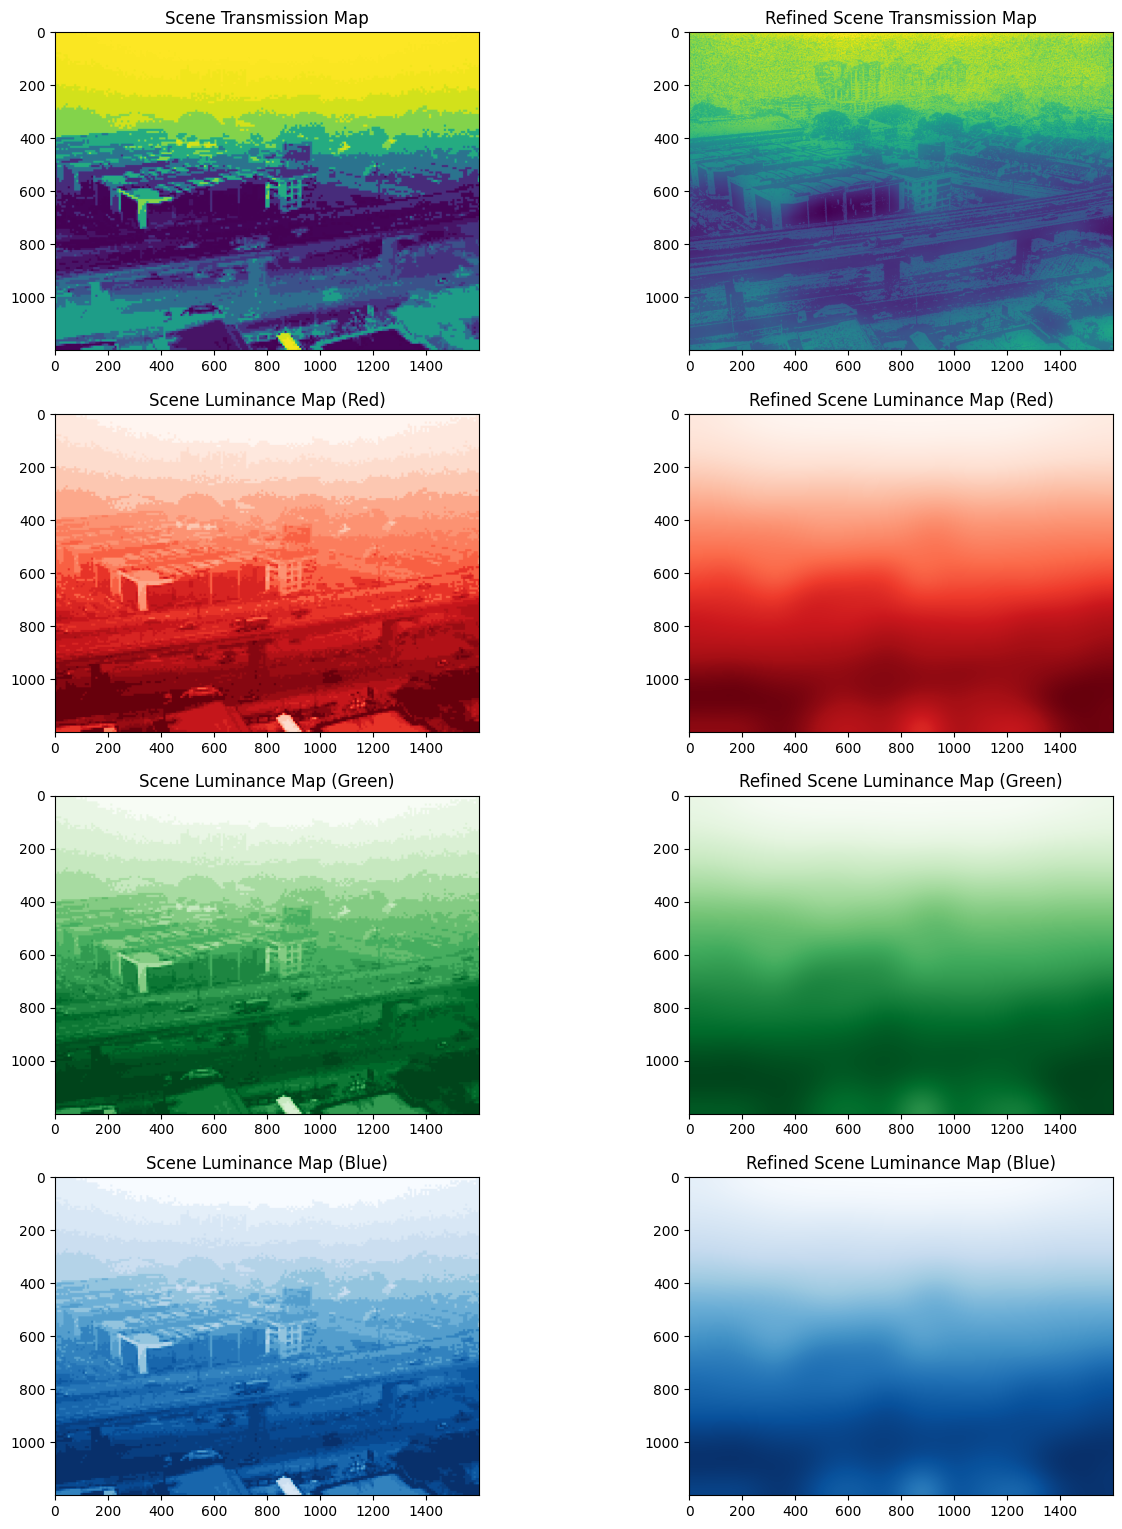

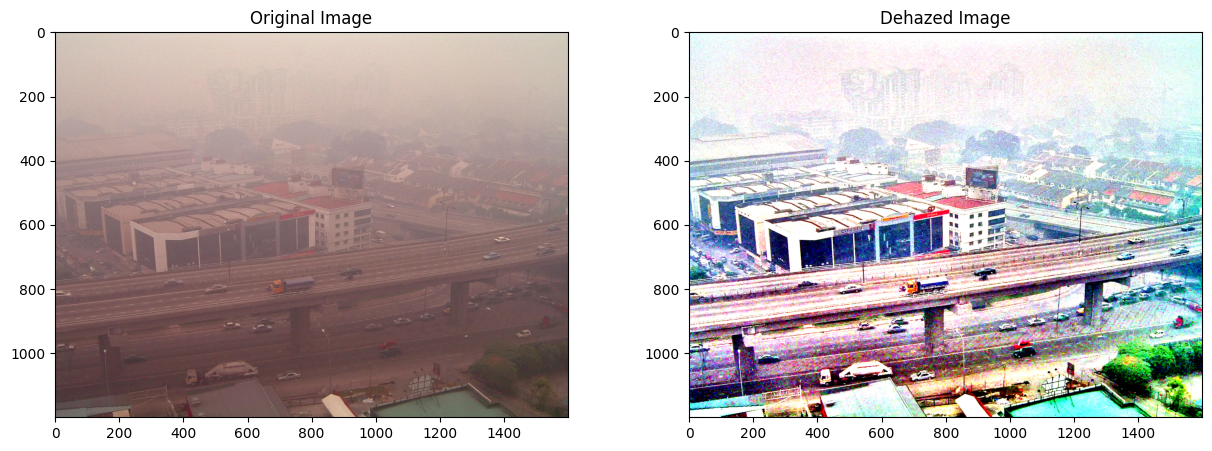

In [14]:
HazeRemoval('img1.jpg', 0.000105, 0.5, 0.5, 0.5, 15, 8)

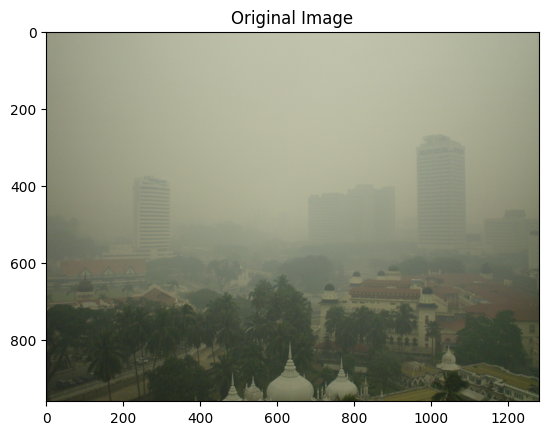

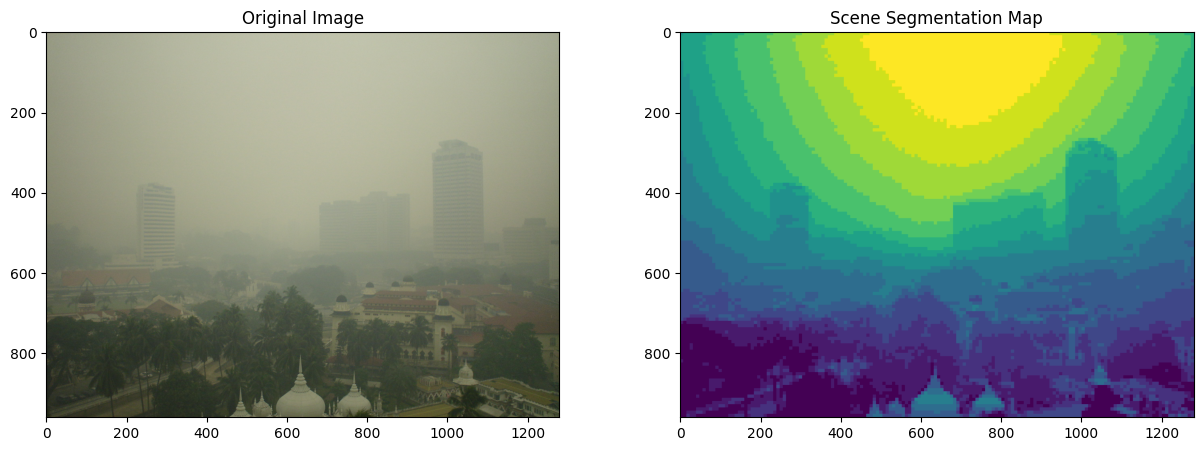

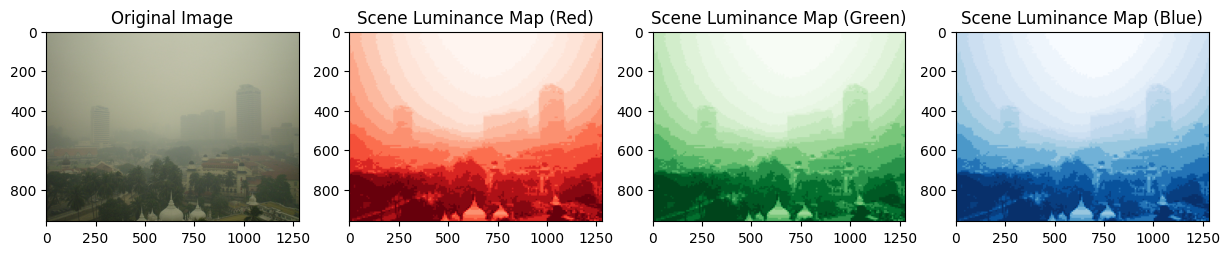

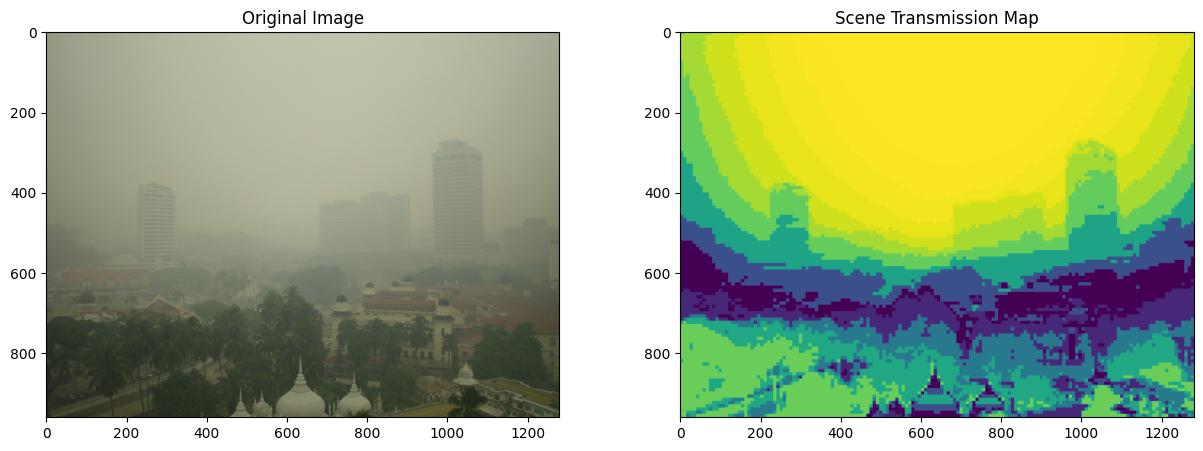

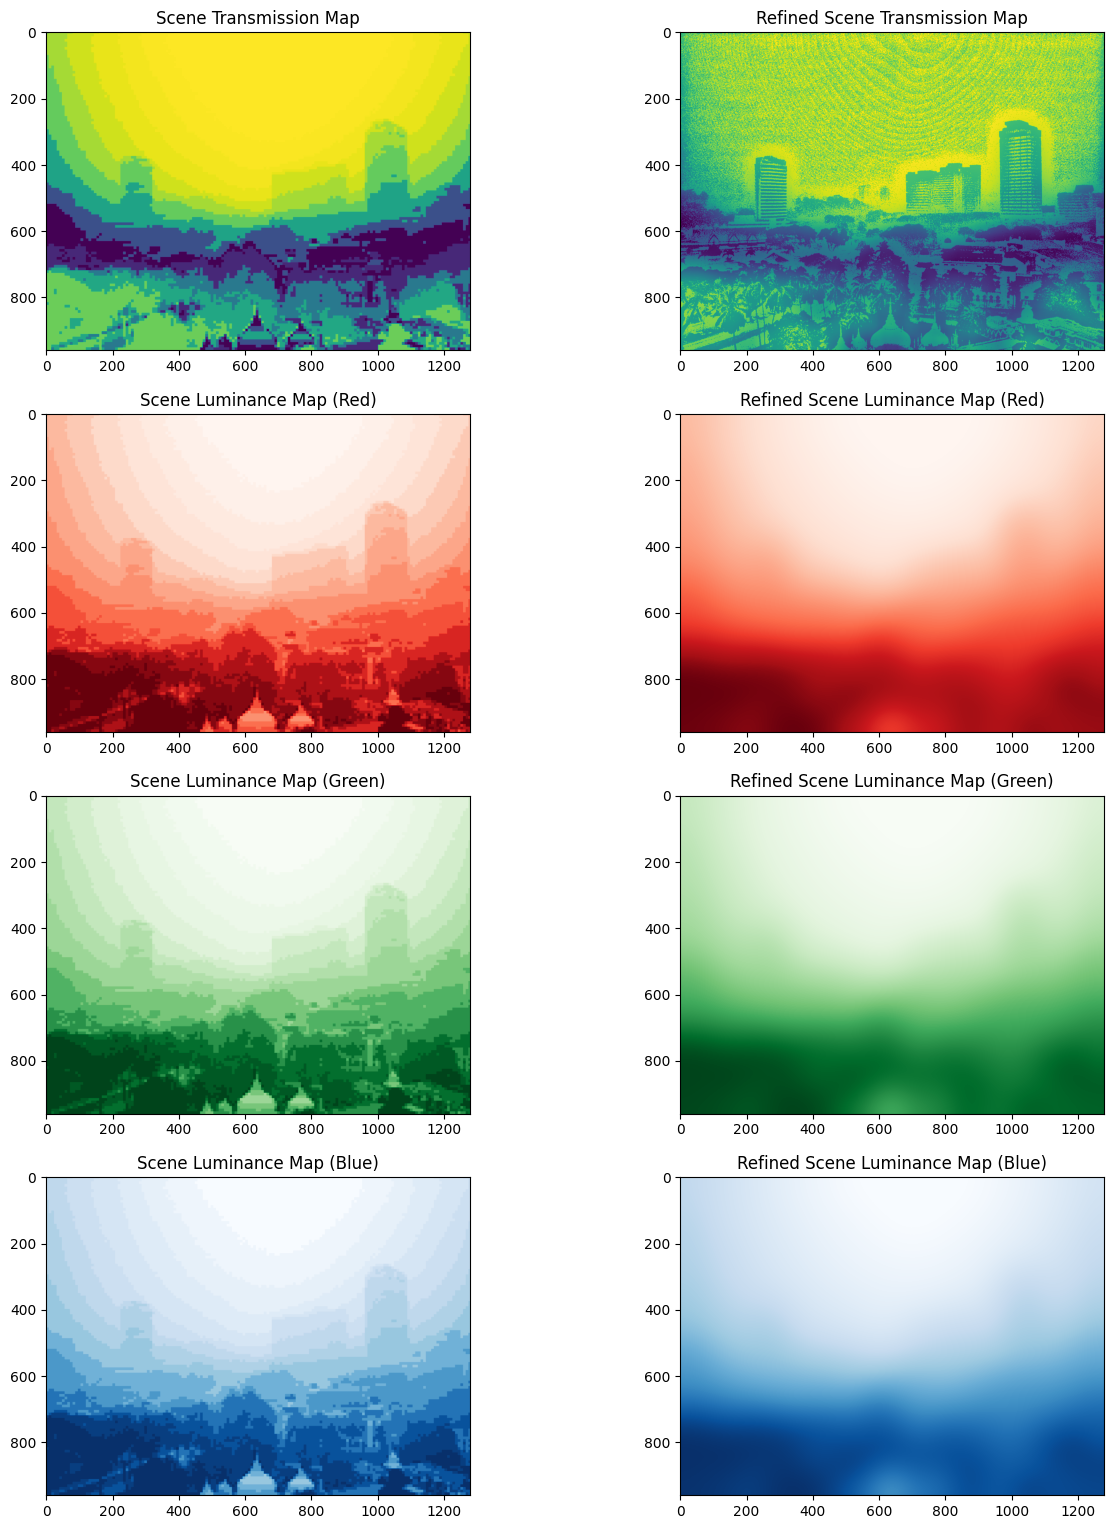

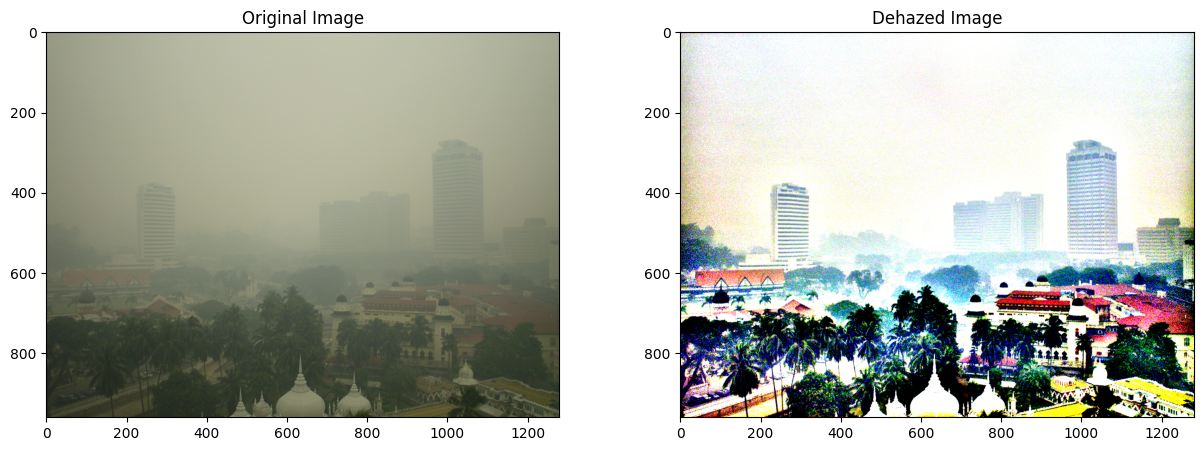

In [15]:
HazeRemoval('img2.jpg', 1e-3, 0.5, 0.5, 0.5, 15, 8)